C:\Users\alindqu1\Desktop\hyst\scd1h.csv
C:\Users\alindqu1\Desktop\results\1.jpg
C:\Users\alindqu1\Desktop\hyst\scp1h.csv


C:\Users\alindqu1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:67: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
C:\Users\alindqu1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:81: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


C:\Users\alindqu1\Desktop\results\2.jpg
C:\Users\alindqu1\Desktop\hyst\St02B_08.csv
C:\Users\alindqu1\Desktop\results\3.jpg


C:\Users\alindqu1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:131: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
C:\Users\alindqu1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:132: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


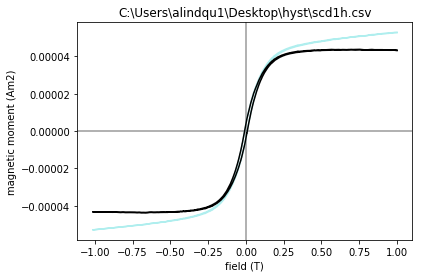

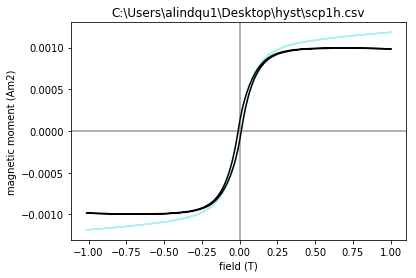

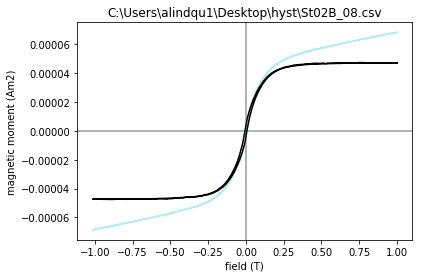

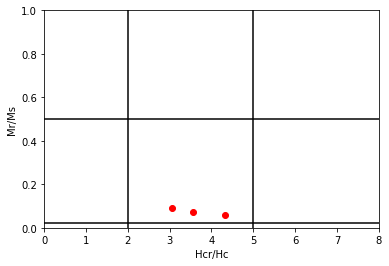

In [53]:
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv
import pylab
from sklearn.linear_model import LinearRegression

########################this should match results folder and needs to be separate from data folder
results = 'C:\\Users\\alindqu1\\Desktop\\results' 
j=1
filename1 = results + '\\hystvalues.csv'
with open(filename1, 'w', newline = "") as f: 
    thewriter = csv.writer(f)

    thewriter.writerow(['file name','Ms','Mr','Hc','Hcr'])
    
##################this should match your data folder
for files in glob.glob(os.path.join('C:\\Users\\alindqu1\\Desktop\\hyst', '*.csv')):
        hyst = pd.read_csv(files) #input file name here
        print(files)
        
#find fit for upper hysteresis slope        
        upper = 0.9*(hyst.moment[0]) #determine which values to use to fit uppper line
        n = 0
        while hyst.moment[n] > upper: #determine which lower bound of data set for fitting line
            n = n + 1
        limup = n

        hystmatrix = np.matrix(hyst) #make data a matrix for fitting a linear regression

        X, Y = hystmatrix[0:limup,0], hystmatrix[0:limup,1]
        fitupper = LinearRegression().fit(X,Y)
        m_upper = fitupper.coef_[0]
        b_upper = fitupper.intercept_
        
        min = int(len(hyst)/2)

#find fit for lower hysteresis slope        
        lower = 0.9*hyst.moment[min] #determine value for bounds on lower data to fit

        i = 0 
        while hyst.moment[i] > lower: #find which two indices include needed data
            i = i + 1
        bound1 = i

        m = min+10
        while hyst.moment[m] < lower:
            m = m + 1
        bound2 = m

        X, Y = hystmatrix[bound1:bound2,0], hystmatrix[bound1:bound2,1]
        fitlower = LinearRegression().fit(X,Y)
        m_lower = fitlower.coef_[0]
        b_lower = fitlower.intercept_
        
#average two lines to find the AFM/PM correction for the hysteresis loop        
        m_upper = float(m_upper) #make slopes and intercepts floats
        m_lower = float(m_lower)
        b_upper = float(b_upper)
        b_lower = float(b_lower)
        m_new = (m_upper+m_lower)/2 #mean to find slope for whole data set
        b_new = (b_upper + b_lower)*(0.5) #find value to adjust vertical shift
        
#and correct the data
        hyst.moment2 = hyst.moment-(m_new*hyst.field)-b_new

#find un-corrected Hc values by fitting slope to line defined by points above and below the x-intercept
        for i in range(0,len(hyst.field)-1):
            if hyst.moment[i] > 0 and hyst.moment[i+1] < 0:
                hc1 = hyst.field[i] - (((hyst.field[i+1]-hyst.field[i])/(hyst.moment[i+1]-hyst.moment[i]))*hyst.moment[i])
            elif hyst.moment[i] < 0 and hyst.moment[i+1] > 0:
                hc2 = hyst.field[i] - (((hyst.field[i+1]-hyst.field[i])/(hyst.moment[i+1]-hyst.moment[i]))*hyst.moment[i])
            else:
                i = i+1

        hc = abs(hc1-(hc1+hc2)*0.5) #find coercivity of sample
    #new x values should = x_original-0.5*(hc1+hc2)
    
        hyst.field2 = hyst.field - (0.5)*(hc1+hc2)

        
#find remanence (Mr)
        for i in range(0,len(hyst.field)-1): 
            if hyst.field[i] > 0 and hyst.field[i+1] < 0:
                mr = hyst.moment[i]-(((hyst.moment[i+1]-hyst.moment[i])/(hyst.field[i+1]-hyst.field[i]))*hyst.field[i])
            else:
                i = i+1
                
                
#find coercivity of remanence (Hcr) and Ms

        for i in range(0,len(hyst.backfield)-1):
            if hyst.backrem[i] > 0 and hyst.backrem[i+1] < 0:
                hcr = hyst.backfield[i] - ((hyst.backfield[i+1]-hyst.backfield[i])/(hyst.backrem[i+1]-hyst.backrem[i])*hyst.backrem[i])
                i = i + 1
            else:
                i = i + 1

        hcr = hcr*(-1)

        ms = hyst.moment[0]
        
#create a jpg of the hysteresis loop
        plt.figure()
        plt.axvline(x=0,color='#999999')
        plt.axhline(y=0,color='#999999')
        plt.plot(hyst.field,(hyst.moment),color='#AFEEEE')
        plt.plot(hyst.field2,(hyst.moment2),color='#000000')
        plt.title(files)
        plt.xlabel('field (T)')
        plt.ylabel('magnetic moment (Am2)')
        name = results + '\\' + str(j) + '.jpg'
        print(name)
        pylab.savefig(name, bbox_inches='tight')
        j = j + 1
        
#write values to a file
        with open(filename1, 'a', newline = "") as f:
            thewriter = csv.writer(f)

            thewriter.writerow([files,ms,mr,hc,hcr])
            
#generate a day plot
plt.figure()
dplot = pd.read_csv(filename1) #change location to match upper folder
dplot.x = dplot.Hcr/dplot.Hc
dplot.y = dplot.Mr/dplot.Ms
plt.plot(dplot.x,dplot.y, 'or')
plt.axvline(x=2,color='#000000')
plt.axvline(x=5,color='#000000')
plt.axhline(y=0.02,color='#000000')
plt.axhline(y=0.5,color='#000000')
plt.ylim([0,1])
plt.xlim([0,8])
plt.ylabel('Mr/Ms')
plt.xlabel('Hcr/Hc')
filename2 = results + '\\dayplot.jpg'
pylab.savefig(filename2)


        